In [63]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tqdm import tqdm

from packages.DataProcessing_fullsize import tfrecords
from packages.DataAugmentation_crop import dataAugmentation
from packages.Model_CNN_Crop import get_model

plt.style.use('_mpl-gallery')

In [2]:
config = json.load(open("./conf/config.json"))

In [3]:
N_SPLITS = 4
IMG_HEIGHT = 1024
IMG_WIDTH = 1024
BATCH_SIZE = 24
EPOCHS = 200
PATIENCE = 10
MAX_LR = config["TrainCycle"]["MAX_LR"]
MIN_LR = config["TrainCycle"]["MIN_LR"]

In [4]:
class_names = np.load("./output/class_names.npy", allow_pickle=True)
num_classes = len(class_names)

In [5]:
train_target = np.load("./output/train_target.npy", allow_pickle=True)
valid_target = np.load("./output/valid_target.npy", allow_pickle=True)

In [6]:
# Reading TFRecords
records = tfrecords(IMG_HEIGHT, IMG_WIDTH)
train_ds = records.get_dataset(f'./output/tfrecords_1024/train.tfrecords')
valid_ds = records.get_dataset(f'./output/tfrecords_1024/valid.tfrecords')

In [7]:
# Data augmentation
aug_train = dataAugmentation("train", 256, 256)
train_ds = train_ds.map(aug_train.augment_iamge, num_parallel_calls=tf.data.AUTOTUNE)
aug_valid = dataAugmentation("valid", 256, 256)
valid_ds = valid_ds.map(aug_valid.augment_iamge, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()

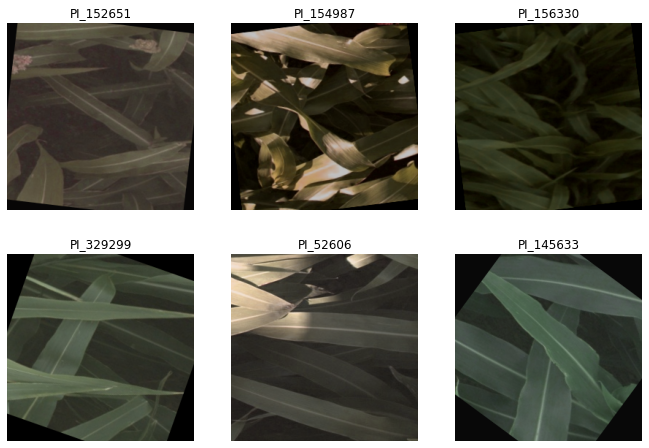

In [9]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(9, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype(np.uint8))
    label = label_batch[i].numpy()
    plt.title(class_names[label])
    plt.axis("off")

In [10]:
# Build Model

model = get_model(input_shape=(256, 256, 3), output_shape=num_classes)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                             

In [12]:
train_classes, train_counts = np.unique(train_target, return_counts=True)

weight = (1/train_counts) * (len(train_target)/num_classes)
class_weight = {i:weight[i] for i in range(len(weight))}

In [13]:
steps_per_epoch = len(train_target)//BATCH_SIZE
validation_steps = len(valid_target)//BATCH_SIZE

In [14]:
model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=MAX_LR,
                                                     total_steps=EPOCHS*steps_per_epoch,
                                                     warmup_proportion=0.1,
                                                     min_lr=MIN_LR), 
              loss=tf.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [15]:
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=PATIENCE, 
                                                monitor='val_loss', 
                                                restore_best_weights=True)

In [16]:
history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    epochs=EPOCHS,
                    callbacks=[my_callbacks],
                    class_weight=class_weight,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/100
693/693 [==============================] - 218s 287ms/step - loss: 4.8333 - accuracy: 0.0100 - val_loss: 4.6467 - val_accuracy: 0.0177
Epoch 2/100
693/693 [==============================] - 203s 292ms/step - loss: 4.6942 - accuracy: 0.0159 - val_loss: 4.5375 - val_accuracy: 0.0236
Epoch 3/100
693/693 [==============================] - 205s 296ms/step - loss: 4.6214 - accuracy: 0.0193 - val_loss: 4.4982 - val_accuracy: 0.0224
Epoch 4/100
693/693 [==============================] - 206s 297ms/step - loss: 4.5432 - accuracy: 0.0213 - val_loss: 4.4332 - val_accuracy: 0.0314
Epoch 5/100
693/693 [==============================] - 208s 300ms/step - loss: 4.4404 - accuracy: 0.0262 - val_loss: 4.3635 - val_accuracy: 0.0307
Epoch 6/100
693/693 [==============================] - 214s 309ms/step - loss: 4.3454 - accuracy: 0.0323 - val_loss: 4.2006 - val_accuracy: 0.0446
Epoch 7/100
693/693 [==============================] - 213s 307ms/step - loss: 4.2696 - accuracy: 0.0437 - val_loss: 4

In [17]:
model.save(f'./output/model_CNN_R_C_f.h5')

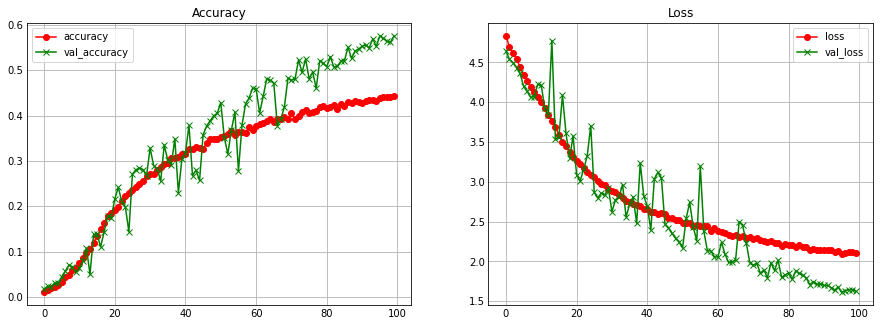

In [18]:
# Validate the Model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Accuracy')
ax1.plot(history.history['accuracy'], 'r', marker="o", label='accuracy')
ax1.plot(history.history['val_accuracy'], 'g', marker="x", label='val_accuracy')
ax1.legend()

ax2.set_title('Loss')
ax2.plot(history.history['loss'], 'r', marker="o", label='loss')
ax2.plot(history.history['val_loss'], 'g', marker="x", label='val_loss')
ax2.legend()

plt.show()

In [19]:
val_preds = model.predict(valid_ds, steps=validation_steps)
val_preds = np.argmax(val_preds, axis=1)

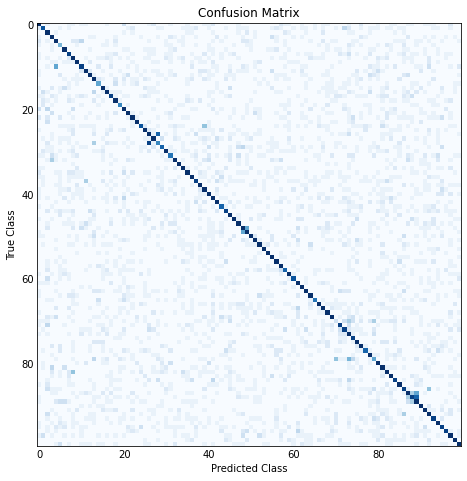

In [22]:
matrix = tf.math.confusion_matrix(valid_target[:validation_steps * BATCH_SIZE], val_preds).numpy()

plt.figure(figsize=(6, 6))
plt.imshow(matrix, vmax=15)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.grid(False)
plt.show()

## Submit the Result

In [24]:
from skimage import io

In [25]:
df = pd.read_csv('./input/sample_submission.csv')

In [68]:
path = './input/test/'
path_test_images = np.array([path+i for i in df['filename']])

In [69]:
def pred_class(path):
    img = io.imread(path)
    splited_image = []
    for i in np.arange(0, 1024, 256):
        for j in np.arange(0, 1024, 256):
            splited_image.append(img[i:i+256, j:j+256, :])
    splited_image = np.array(splited_image)
    y_pred_splited = model.predict(splited_image)
    return class_names[np.argmax(y_pred_splited.max(axis=0))]

In [70]:
pred_cultivar = []
for path in tqdm(path_test_images):
    pred_cultivar.append(pred_class(path))

100%|██████████| 23639/23639 [1:19:07<00:00,  4.98it/s]


In [71]:
df['cultivar'] = pred_cultivar
df.to_csv(f'./output/CNN_R_C_f.csv', index=False)